In [2]:
# Evaluation mean f1-score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

X = np.load('data/train_data.npy')
# classes 0 - 3
y = np.genfromtxt('data/train_labels.csv', delimiter=' ', dtype=np.float32)

unique, counts = np.unique(y, return_counts=True)
print(counts) # features: 18286

[4040 1965  227  590]


In [169]:
from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=384, n_jobs=-1)

ind_train = np.concatenate((np.where(y == 0)[0][0:3000], np.where(y == 1)[0][:1500], np.where(y == 2)[0][:180], np.where(y == 3)[0][:450]))
ind_test = list(set(range(0, len(X))) - set(ind_train))

X_train = np.take(X, ind_train, axis=0)
y_train = np.take(y, ind_train, axis=0)
X_test = np.take(X, ind_test, axis=0)
y_test = np.take(y, ind_test, axis=0)

#X_train, y_train = sm.fit_sample(X_train, y_train)
unique, counts = np.unique(y_train, return_counts=True)
print(counts) # features: 18286

def sampleIt(X, y):
    X_new = []; y_new = []; sample_w = []
    for i, row_y in enumerate(y):
        for cl, p_i in enumerate(row_y):
            X_new.append(X[i])
            y_new.append(cl)
            sample_w.append(p_i)
    return X_new, y_new, sample_w

# X_train, y_train, w_train = sampleIt(X_train, y_train)
# X_test, y_test, w_test = sampleIt(X_test, y_test)

[3000 1500  180  450]


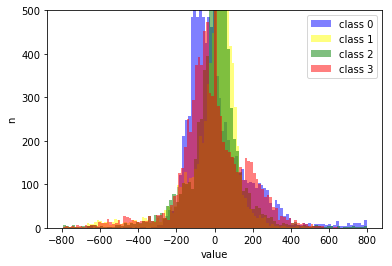

In [88]:
min_v = -800; max_v = 800;
plt.hist(X[0][(X[0] > min_v) & (X[0] < max_v) ], 100, facecolor='blue', alpha=0.5, label='class 0')
plt.hist(X[3][(X[3] > min_v) & (X[3] < max_v) ], 100, facecolor='yellow', alpha=0.5, label='class 1')
plt.hist(X[45][(X[45] > min_v) & (X[45] < max_v) ], 100, facecolor='green', alpha=0.5, label='class 2')
plt.hist(X[500][(X[500] > min_v) & (X[500] < max_v) ], 100, facecolor='red', alpha=0.5, label='class 3')
plt.ylim([0, 500])
plt.xlabel('value'); plt.ylabel('n'); plt.legend(); plt.show()

In [183]:
from sklearn.base import BaseEstimator, TransformerMixin
import random
random.seed(99)

class RandomBinsExtraction(BaseEstimator, TransformerMixin):
    """Build n bins with mean from values"""
    def __init__(self, splits=100, hist_bins=None):
        self.splits = splits
        self.hist_bins = hist_bins
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_new = []
        if self.hist_bins is None:
            self.hist_bins = [array([-1010.17341354,  -474.60101701,  -323.4648798 ,  -298.58255363,
        -171.09329843,    35.30911117,    54.23368689,   281.97691454,
         362.18904175,   763.24310269,  1054.64905874]), array([-1021.55849226,  -622.3972264 ,  -546.46864382,  -293.25237117,
         -90.21258189,   -87.9444529 ,    98.46365734,   104.10726152,
         287.93028676,   509.16586464,   894.95370198]), array([-1057.15186037,  -579.82684296,  -402.01738448,  -347.85151845,
        -172.23421159,  -118.19510317,    98.55559453,   274.68542736,
         299.37070188,   688.3919158 ,  1049.00414574])]
            
        for row in X:
            splits = np.array_split(row, int(self.splits))
                
            features = []
            for j, split in enumerate(splits):
                i = int(j / len(splits) * len(self.hist_bins))
                features.append(np.histogram(split, bins=self.hist_bins[i])[0])
                #features.append(np.histogram(split, bins=self.hist_bins)[0])

            X_new.append(np.array(features).flatten())

        #print("features: "+str(len(X_new[0])))
        return X_new
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.svm import LinearSVC

pipe = Pipeline([
    ('BinsExtraction', RandomBinsExtraction(splits=80)),
    ('scaler', StandardScaler()),
#    ('logreg', LogisticRegression(C=1.0, solver='liblinear', n_jobs=-1))
    ('logreg', GradientBoostingClassifier(n_estimators=30))
#      ('linearSVC', LinearSVC(C=1.0, max_iter=1000))
])

In [184]:
from sklearn.metrics import f1_score, log_loss

# pipe.fit(X_train, y_train, **{'logreg__sample_weight': w_train}); print('fitted')
pipe.fit(X_train, y_train); print('fitted')
y_pred = pipe.predict(X_test);
print("f1 score: {}".format(f1_score(y_test, y_pred, average='micro') ))

unique, counts = np.unique(y_pred, return_counts=True)
print(counts); print(len(y_test[y_test==0]) / len(y_test))

# Pass score: 0.62837
# Splits 80: 0.5739644970414202 (first class 2000 rows)
# GradientBoostingClassifier, 100, 0.6505588428665352
# 30, 0.6794871794871795 / 0.7176820208023774 [2200  463   26    3]
# Smote 4x2000: 0.5197409006785935
# 3k: 0.644

fitted
f1 score: 0.6306146572104019
[1534  143   13    2]
0.6146572104018913


In [189]:
import random
def run(a):
    pipe = Pipeline([
        ('BinsExtraction', RandomBinsExtraction(splits=80, hist_bins=a)),
        ('scaler', StandardScaler()),
 #       ('logreg', LogisticRegression(C=1.0, solver='liblinear', n_jobs=2))
        ('logreg', GradientBoostingClassifier(n_estimators=30))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test);

    score = f1_score(y_test, y_pred, average='micro')
    print("\x1b[1;31m%s\x1b[0m \t%s" % (score, a))
    
#for i in [0.01, 0.1, 1, 10]:
#    run(i)
hist_bins = [np.array([-1083.59921692,  -476.33763822,  -391.50489743,  -355.60320737,
        -158.43665552,   -14.84714956,    94.77981205,   218.64467678,
         346.5553962 ,   734.50802575,  1002.02972199]), np.array([-1019.66220701,  -523.43519633,  -379.07005136,  -331.66828082,
        -156.15875706,    18.12736061,    39.05190812,   258.69304456,
         372.82923485,   730.21415049,  1041.77824411]), np.array([-1092.05133913,  -467.36450973,  -323.77895088,  -276.7100964 ,
        -177.65586773,   -29.1918839 ,    95.14627871,   267.45422342,
         319.30367525,   752.0415106 ,  1031.95221106]), np.array([-1026.0900565 ,  -550.04804846,  -487.69032655,  -306.6158703 ,
        -166.89823442,   -61.82025277,   108.66079029,   124.07144747,
         274.9071339 ,   519.71265528,   911.63967546]), np.array([-1012.82800316,  -526.8370896 ,  -425.31935619,  -369.87368713,
        -134.25612587,  -125.16553721,   137.63442111,   221.84134438,
         308.374747  ,   698.18557519,  1044.20382967])]
#hist_bins = [[-1063.23640194,  -502.03339032,  -422.5276436,   -286.42136028,   -97.20735832,   -55.16501241,   123.49800188 ,  206.09874563 ,  337.38048621,   637.69219956,   939.23230402]]
for i in range(100):
    bins_new = []
    for b1 in hist_bins:
        bins_new2 = []
        for b2 in b1:
            bins_new2.append(random.uniform(b2 - 50, b2 + 50))
        bins_new.append(np.sort(bins_new2))
    run(bins_new)

0.635342789598 	[array([-1102.93602329,  -481.54995842,  -391.49443812,  -342.15136352,
        -162.49194747,   -49.9454637 ,    77.69166443,   181.51982529,
         346.80456167,   745.87331079,  1012.21674178]), array([-1062.60499902,  -517.85664829,  -350.93449452,  -324.37709794,
        -172.38280704,    29.00688604,    46.66791282,   288.03618475,
         323.88361972,   689.0564641 ,  1037.56814238]), array([-1133.68542937,  -497.85425184,  -280.45705223,  -249.04169388,
        -197.7839754 ,   -67.73865162,   118.28583316,   286.62696642,
         288.26161655,   757.53865974,  1046.06747323]), array([-1067.19030399,  -588.89210018,  -535.17611549,  -272.86430045,
        -187.12110885,   -78.3424446 ,    62.9427883 ,   138.94354988,
         249.91801732,   523.93879046,   896.5840244 ]), array([-1028.0172797 ,  -572.53542633,  -442.81061435,  -328.60693021,
         -89.9338351 ,   -83.77226073,   172.71650148,   252.93795615,
         321.18100276,   708.67165973,  1066.

KeyboardInterrupt: 

In [67]:
# Get clusters as a start for the bins
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9, n_jobs=-1, random_state=99)#, init="k-means++")

ind = np.concatenate((np.where(y == 0)[0][0:3], np.where(y == 1)[0][:3], np.where(y == 2)[0][:3], np.where(y == 3)[0][:3]))
samples = np.take(X, ind, axis=0)
centers = []
for i, sample in enumerate(samples):
    sample = sample[(sample > -500) & (sample < 500)]
    kmeans.fit(np.array([sample]).T)
    centers.append(np.sort(np.array(kmeans.cluster_centers_).flatten()))
    print(str(i+1) + ' / ' + str(len(samples)))

if False: # use all centers
    values = np.array(centers).flatten()
    values = np.sort(values)
else: # take means of centers
    values = np.mean(centers, axis=0)

#edges = [1] # leave out 0
for center_1, center_2 in zip(values[:-1], values[1:]):
    edges.append(.5 * (center_1 + center_2))
#edges.append(1700)
"""

"""
edges

Process ForkPoolWorker-131:
Process ForkPoolWorker-132:
Process ForkPoolWorker-130:
Process ForkPoolWorker-129:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/pyt

KeyboardInterrupt: 